In [ ]:
# GPU 런타임 환경으로 변경

In [ ]:
!pip show autokeras

In [ ]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.2/465.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.0 MB/s eta 0:00:00


In [ ]:
!pip show autokeras

Name: autokeras
Version: 1.1.0
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: DATA Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: keras-nlp, keras-tuner, packaging, pandas, tensorflow
Required-by: 


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: autokeras, dopamine-rl, tensorflow-text


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import autokeras as ak

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder    # 문자열, NaN -> 수치화
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:
    # rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai/dnn/economic_auto' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# ---------------------------------------------------------------------

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Using TensorFlow backend


In [ ]:
df = pd.read_csv('./economic.csv')
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(12141, 29)


In [ ]:
df.head(3)

,fund_name,fund_extended_name,category,net_assets,ytd_return,fund_yield,morningstar_rating,investment,size,currency,portfolio_cash,portfolio_stocks,portfolio_bonds,price_earnings,price_sales,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology,fund_return_2018,fund_return_2017,fund_return_2016
0,AAAAX,DWS RREEF Real Assets Fund - Class A,World Allocation,5.302800e+08,12.79,1.43,3.0,Blend,Large,USD,3.80,76.25,15.35,21.58,2.32,7.48,0.16,0.00,39.52,0.93,0.00,19.56,5.02,17.03,9.24,1.08,-5.37,14.67,4.01
1,AAAGX,Thrivent Large Cap Growth Fund Class A,Large Growth,1.080000e+09,16.00,0.00,3.0,Growth,Large,USD,1.91,97.06,0.00,24.49,4.45,0.00,20.20,16.12,0.00,3.99,16.52,0.00,0.00,0.78,7.08,35.30,1.48,27.70,-2.26
2,AAAIX,American Century Strategic Allocation: Aggress...,Allocation - 70% to 85% Equity,7.852700e+08,11.57,1.38,4.0,Growth,Large,USD,2.57,75.06,22.29,15.92,1.50,2.37,14.71,16.03,5.43,7.20,12.71,1.87,1.77,5.36,11.25,21.30,-7.71,19.31,6.95


In [ ]:
cols = df.columns.values
print(cols)

['fund_name' 'fund_extended_name' 'category' 'net_assets' 'ytd_return'
 'fund_yield' 'morningstar_rating' 'investment' 'size' 'currency'
 'portfolio_cash' 'portfolio_stocks' 'portfolio_bonds' 'price_earnings'
 'price_sales' 'basic_materials' 'consumer_cyclical' 'financial_services'
 'real_estate' 'consumer_defensive' 'healthcare' 'utilities'
 'communication_services' 'energy' 'industrials' 'technology'
 'fund_return_2018' 'fund_return_2017' 'fund_return_2016']


In [ ]:
df.info() # object: 문자열
# Id  1460 non-null   int64: 8바이트 정수형 1460개 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fund_name               12141 non-null  object 
 1   fund_extended_name      12141 non-null  object 
 2   category                12141 non-null  object 
 3   net_assets              12141 non-null  float64
 4   ytd_return              12141 non-null  float64
 5   fund_yield              12141 non-null  float64
 6   morningstar_rating      12141 non-null  float64
 7   investment              11613 non-null  object 
 8   size                    11613 non-null  object 
 9   currency                12141 non-null  object 
 10  portfolio_cash          12141 non-null  float64
 11  portfolio_stocks        12141 non-null  float64
 12  portfolio_bonds         12141 non-null  float64
 13  price_earnings          12141 non-null  float64
 14  price_sales             12141 non-null

In [ ]:
df.isnull().sum()

fund_name                   0
fund_extended_name          0
category                    0
net_assets                  0
ytd_return                  0
fund_yield                  0
morningstar_rating          0
investment                528
size                      528
currency                    0
portfolio_cash              0
portfolio_stocks            0
portfolio_bonds             0
price_earnings              0
price_sales                 0
basic_materials             0
consumer_cyclical           0
financial_services          0
real_estate                 0
consumer_defensive          0
healthcare                  0
utilities                   0
communication_services      0
energy                      0
industrials                 0
technology                  0
fund_return_2018            0
fund_return_2017            0
fund_return_2016            0
dtype: int64

In [ ]:
print(df.head(1)) # 문자를 숫자형으로 변경해야 학습 가능

  fund_name                    fund_extended_name          category  \
0     AAAAX  DWS RREEF Real Assets Fund - Class A  World Allocation   

    net_assets  ytd_return  fund_yield  morningstar_rating investment   size  \
0  530280000.0       12.79        1.43                 3.0      Blend  Large   

  currency  portfolio_cash  portfolio_stocks  portfolio_bonds  price_earnings  \
0      USD             3.8             76.25            15.35           21.58   

   price_sales  basic_materials  consumer_cyclical  financial_services  \
0         2.32             7.48               0.16                 0.0   

   real_estate  consumer_defensive  healthcare  utilities  \
0        39.52                0.93         0.0      19.56   

   communication_services  energy  industrials  technology  fund_return_2018  \
0                    5.02   17.03         9.24        1.08             -5.37   

   fund_return_2017  fund_return_2016  
0             14.67              4.01  


In [ ]:
# print(df['Id'].dtype)
# print(df['MSZoning'].dtype) # 문자열

In [ ]:
# df.drop(['fund_name', 'fund_extended_name'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category                12141 non-null  object 
 1   net_assets              12141 non-null  float64
 2   ytd_return              12141 non-null  float64
 3   fund_yield              12141 non-null  float64
 4   morningstar_rating      12141 non-null  float64
 5   investment              11613 non-null  object 
 6   size                    11613 non-null  object 
 7   currency                12141 non-null  object 
 8   portfolio_cash          12141 non-null  float64
 9   portfolio_stocks        12141 non-null  float64
 10  portfolio_bonds         12141 non-null  float64
 11  price_earnings          12141 non-null  float64
 12  price_sales             12141 non-null  float64
 13  basic_materials         12141 non-null  float64
 14  consumer_cyclical       12141 non-null

In [ ]:
# df.fillna(0, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category                12141 non-null  object 
 1   net_assets              12141 non-null  float64
 2   ytd_return              12141 non-null  float64
 3   fund_yield              12141 non-null  float64
 4   morningstar_rating      12141 non-null  float64
 5   investment              11613 non-null  object 
 6   size                    11613 non-null  object 
 7   currency                12141 non-null  object 
 8   portfolio_cash          12141 non-null  float64
 9   portfolio_stocks        12141 non-null  float64
 10  portfolio_bonds         12141 non-null  float64
 11  price_earnings          12141 non-null  float64
 12  price_sales             12141 non-null  float64
 13  basic_materials         12141 non-null  float64
 14  consumer_cyclical       12141 non-null

In [ ]:
# 상관 분석, 상관이 강할수록 정확도가 높고 학습이 잘됨.
# 예) 집값이 높아지면 컴퓨터 속도가 빨라짐? 상관성이 없음으로 학습이 안됨

# X측: LotFrontage, Y측: LotFrontage -> 1, 강한상관 자기 자신
# X측: LotFrontage, Y측: SalePrice -> 0.351799, 양의 상관,
# LotFrontage(집 앞 마당): 마당(X 축)이 넓어지면 집 가격(Y 축)은 상승한다.
# X측: LotShape, Y측: SalePrice -> -0.255580, 음의 상관,
# LotShape(대지의 모양): 부지의 모양이 너무 각이 많아지면 집값이 떨어짐.

# df_corr = df.corr()
# df_corr

In [ ]:
# df_corr.sort_values('SalePrice', ascending=False, inplace=True) # SalePrice 컬럼 기준 내림차순 정렬
# df_corr['SalePrice'].head(10) # 상관계수가 가장높은 컬럼 10개 출력

In [ ]:
# print(type(df_corr['SalePrice'].head(10))) # 하나의 컬럼, 1차원과 비슷
# print(df_corr['SalePrice'].head(10).index) # 상관 관계에서 컬럼명이 index

In [ ]:
# cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
#        'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
# sb.pairplot(df[cols])
# plt.show()

In [ ]:
Y = df.pop('TARGET1')
print(Y.shape)

(12141,)


In [ ]:
Y.head(3)

0    12.79
1    16.00
2    11.57
Name: ytd_return, dtype: float64

In [ ]:
cols = df.columns.values
print(cols)

['category' 'net_assets' 'fund_yield' 'morningstar_rating' 'investment'
 'size' 'currency' 'portfolio_cash' 'portfolio_stocks' 'portfolio_bonds'
 'price_earnings' 'price_sales' 'basic_materials' 'consumer_cyclical'
 'financial_services' 'real_estate' 'consumer_defensive' 'healthcare'
 'utilities' 'communication_services' 'energy' 'industrials' 'technology'
 'fund_return_2018' 'fund_return_2017' 'fund_return_2016']


In [ ]:
df.head(3)

,category,net_assets,fund_yield,morningstar_rating,investment,size,currency,portfolio_cash,portfolio_stocks,portfolio_bonds,price_earnings,price_sales,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology,fund_return_2018,fund_return_2017,fund_return_2016
0,World Allocation,5.302800e+08,1.43,3.0,Blend,Large,USD,3.80,76.25,15.35,21.58,2.32,7.48,0.16,0.00,39.52,0.93,0.00,19.56,5.02,17.03,9.24,1.08,-5.37,14.67,4.01
1,Large Growth,1.080000e+09,0.00,3.0,Growth,Large,USD,1.91,97.06,0.00,24.49,4.45,0.00,20.20,16.12,0.00,3.99,16.52,0.00,0.00,0.78,7.08,35.30,1.48,27.70,-2.26
2,Allocation - 70% to 85% Equity,7.852700e+08,1.38,4.0,Growth,Large,USD,2.57,75.06,22.29,15.92,1.50,2.37,14.71,16.03,5.43,7.20,12.71,1.87,1.77,5.36,11.25,21.30,-7.71,19.31,6.95


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category                12141 non-null  object 
 1   net_assets              12141 non-null  float64
 2   fund_yield              12141 non-null  float64
 3   morningstar_rating      12141 non-null  float64
 4   investment              11613 non-null  object 
 5   size                    11613 non-null  object 
 6   currency                12141 non-null  object 
 7   portfolio_cash          12141 non-null  float64
 8   portfolio_stocks        12141 non-null  float64
 9   portfolio_bonds         12141 non-null  float64
 10  price_earnings          12141 non-null  float64
 11  price_sales             12141 non-null  float64
 12  basic_materials         12141 non-null  float64
 13  consumer_cyclical       12141 non-null  float64
 14  financial_services      12141 non-null

In [ ]:
# 수치 컬럼 NaN -> 0
for col in cols:
    if (df[col].dtype != 'object'): # 컬럼의 타입이 object인 컬럼 산출
        # print('Not object NaN founded.')
        df[col].fillna(0, inplace=True)

In [ ]:
# 데이터 전처리, 문자열 -> 정수로 변경
# encoder = LabelEncoder()
# for col in cols:
#     if (df[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
#         # print('object')
#         df[col] = encoder.fit_transform(df[col]) # 0 ~ 고유한 정수로 변경

encoder_category = LabelEncoder()
encoder_category.fit(df['category']) # 0 ~ 고유한 정수로 변경
df['category'] = encoder_category.transform(df['category']) # 0 ~ 고유한 정수로 변경

df['category'].head()

0    97
1    41
2     3
3    97
4     3
Name: category, dtype: int64

In [ ]:
encoder_investment = LabelEncoder()
encoder_investment.fit(df['investment']) # 0 ~ 고유한 정수로 변경
df['investment'] = encoder_investment.transform(df['investment']) # 0 ~ 고유한 정수로 변경

df['investment'].head()

0    0
1    1
2    1
3    0
4    1
Name: investment, dtype: int64

In [ ]:
encoder_size = LabelEncoder()
encoder_size.fit(df['size']) # 0 ~ 고유한 정수로 변경
df['size'] = encoder_size.transform(df['size']) # 0 ~ 고유한 정수로 변경

df['investment'].head()

0    0
1    1
2    1
3    0
4    1
Name: investment, dtype: int64

In [ ]:
encoder_currency = LabelEncoder()
encoder_currency.fit(df['currency']) # 0 ~ 고유한 정수로 변경
df['currency'] = encoder_currency.transform(df['currency']) # 0 ~ 고유한 정수로 변경

df['currency'].head()

0    0
1    0
2    0
3    0
4    0
Name: currency, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category                12141 non-null  int64  
 1   net_assets              12141 non-null  float64
 2   fund_yield              12141 non-null  float64
 3   morningstar_rating      12141 non-null  float64
 4   investment              12141 non-null  int64  
 5   size                    12141 non-null  int64  
 6   currency                12141 non-null  int64  
 7   portfolio_cash          12141 non-null  float64
 8   portfolio_stocks        12141 non-null  float64
 9   portfolio_bonds         12141 non-null  float64
 10  price_earnings          12141 non-null  float64
 11  price_sales             12141 non-null  float64
 12  basic_materials         12141 non-null  float64
 13  consumer_cyclical       12141 non-null  float64
 14  financial_services      12141 non-null

In [ ]:
X = df
print(X.shape)
print(X.head(1))

(12141, 26)
   category   net_assets  fund_yield  morningstar_rating  investment  size  \
0        97  530280000.0        1.43                 3.0           0     0   

   currency  portfolio_cash  portfolio_stocks  portfolio_bonds  \
0         0             3.8             76.25            15.35   

   price_earnings  price_sales  basic_materials  consumer_cyclical  \
0           21.58         2.32             7.48               0.16   

   financial_services  real_estate  consumer_defensive  healthcare  utilities  \
0                 0.0        39.52                0.93         0.0      19.56   

   communication_services  energy  industrials  technology  fund_return_2018  \
0                    5.02   17.03         9.24        1.08             -5.37   

   fund_return_2017  fund_return_2016  
0             14.67              4.01  


In [ ]:
# 예측을 위한 회귀모델링은 표준화 생략 가능.
# scaler = StandardScaler()
# X = scaler.fit_transform(df)
# print(X[:3])
# X=df

In [ ]:
# 데이터 분할, 훈련+검증: 90%(훈련: 80%, 검증: 20%), 테스트: 5%
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True, random_state=0)
print(x_train.shape) # 훈련+검증: 1314 건, 독립변수 9개
print(y_train.shape) # 훈련+검증: 1314 건, Target(종속변수) 1개, SalePrice
print(x_test.shape)  # 테스트: 146 건, 독립변수 9개
print(y_test.shape)  # 테스트: 146 건, Target(종속변수) 1개, SalePrice

(11533, 26)
(11533,)
(608, 26)
(608,)


In [ ]:
print(type(x_train))
print(x_train.head(1))

<class 'pandas.core.frame.DataFrame'>
      category   net_assets  fund_yield  morningstar_rating  investment  size  \
9088        88  128910000.0        3.06                 3.0           0     0   

      currency  portfolio_cash  portfolio_stocks  portfolio_bonds  \
9088         0           24.85             46.57            22.69   

      price_earnings  price_sales  basic_materials  consumer_cyclical  \
9088           11.77         1.31             4.25              12.88   

      financial_services  real_estate  consumer_defensive  healthcare  \
9088               16.05         2.99                7.51       12.09   

      utilities  communication_services  energy  industrials  technology  \
9088       3.18                    2.62    7.18        11.07       20.17   

      fund_return_2018  fund_return_2017  fund_return_2016  
9088             -7.54             16.09               6.6  


In [ ]:
print(y_train.head(1))

9088    8.77
Name: ytd_return, dtype: float64


In [ ]:
# Tensowflow
# 모델 설계, Node, Epochs, batch_size
# SEED = 0
# os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# tf.random.set_seed(SEED) # Global seed
# np.random.seed(SEED)
# random.seed(SEED)

# model = Sequential()
# model.add(Dense(30, input_dim=8, activation='linear', name='layer1'))
# model.add(Dense(20, activation='linear', name='layer2'))
# model.add(Dense(1, activation='linear', name='layer5'))
# model.compile(optimizer=Adam(lr=0.001), loss='mse')
# model.summary()

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
# es = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

# hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
#                  epochs=1000, batch_size=10, callbacks=[es])

In [ ]:
# print(type(x_train))
# print(type(y_train))
# print(type(x_train.to_numpy()))
# print(type(y_train.to_numpy()))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Autokeras
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# AutoKeras를 사용하여 구조화된 데이터에 대한 회귀 모델을 생성합니다.
# 사용할 옵티마이저 정의 (Adam 옵티마이저, 학습률=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # 기본값 Adam, 0.001
    # optimizer=optimizer,
akmodel = ak.StructuredDataRegressor(
    max_trials=3,  # 최대 시도 횟수를 1로 설정합니다. 이는 AutoKeras가 탐색할 모델 구성의 최대 개수입니다.
    overwrite=True,  # 이전에 실행한 모델 훈련 세션을 덮어쓸지 여부를 결정합니다. True이면 이전 세션을 덮어씁니다.
    metrics=['mse']  # 모델 평가 기준으로 평균 제곱 오차(Mean Squared Error, MSE)를 사용합니다.
)

import os, datetime
# 로그 디렉토리 생성: 현재 시간을 기반으로한 포맷으로 생성됨
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard 콜백 정의:
# - logdir: TensorBoard가 생성된 로그 파일을 저장할 디렉토리 경로
# - histogram_freq=0: 히스토그램 시각화를 얼마나 자주 기록할지를 설정합니다.
#   여기서는 0으로 설정하여 히스토그램을 기록하지 않음을 의미합니다. Autokeras는 0을 지정해야함.
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# 모델을 훈련합니다. x_train은 입력 데이터, y_train은 타겟 데이터입니다.
#     batch_size=10,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
#     validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용합니다. 이는 모델의 성능을 검증하기 위해 사용됩니다.
start = time.time()
akmodel.fit(
    x_train,
    y_train,
    validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용합니다. 이는 모델의 성능을 검증하기 위해 사용됩니다.
    epochs=10,  # 전체 훈련 데이터셋에 대해 모델을 5번 반복 훈련합니다. 기본 1000
    batch_size=32,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
    callbacks=[tensorboard_callback, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start)) # Colab: 130.44 s

Trial 3 Complete [00h 00m 31s]
val_loss: 3.13029408454895

Best val_loss So Far: 2.9720394611358643
Total elapsed time: 00h 01m 31s
Epoch 1/10
361/361 [==============================] - 3s 5ms/step - loss: 23.4444 - mse: 23.4444
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 6.0131 - mse: 6.0131
Epoch 3/10
361/361 [==============================] - 3s 7ms/step - loss: 4.3090 - mse: 4.3090
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 3.8067 - mse: 3.8067
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 3.4978 - mse: 3.4978
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 3.2690 - mse: 3.2690
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 3.0837 - mse: 3.0837
Epoch 8/10
361/361 [==============================] - 3s 8ms/step - loss: 2.9355 - mse: 2.9355
Epoch 9/10
361/361 [==============================] - 2s 5ms/step - loss: 2.8086 - mse: 2.8086
Epoch 10/10

In [ ]:
!kill 8079

In [ ]:
# Tensorboard
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs
# %tensorboard --logdir logs  --host localhost

In [ ]:
# # 시각화
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, loss_ax = plt.subplots()
# # plt.figure(figsize=(6,4)) # ERROR
# fig.set_size_inches(10, 5)  # 챠트 크기 설정

# # 왼쪽 y 축 설정
# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 지원 안됨
# loss_ax.set_ylim([0.0, 3613289216.0000]) # 값을 반영하여 변경 ★

# # 축 레이블 설정
# loss_ax.set_xlabel('epoch')  # 학습 횟수
# loss_ax.set_ylabel('loss')   # 오차

# loss_ax.legend(loc='upper left') # 오차 레이블 위치

# plt.show()
# # train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# # val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.


In [ ]:
akmodel.evaluate(x_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 3.2815


3.281487226486206

In [ ]:
# First we export the model to a keras model
model = akmodel.export_model()

# Now, we ask for the model Sumary:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 multi_category_encoding (M  (None, 26)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 26)                53        
 on)                                                             
                                                                 
 dense (Dense)               (None, 32)                864       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

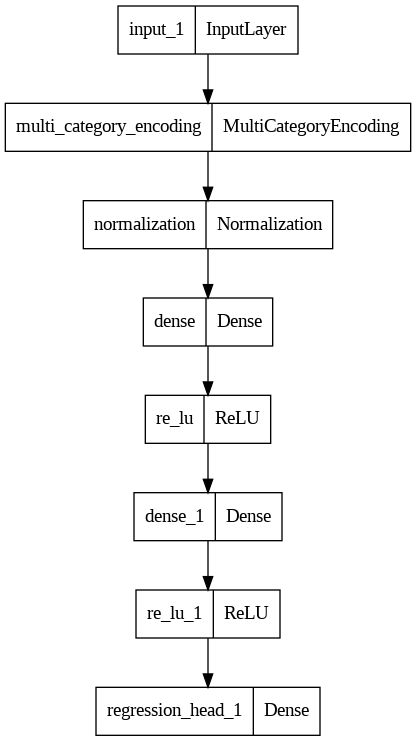

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.save("Mfund_auto_model", save_format="tf")

In [ ]:
model = load_model("Mfund_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# y_test_p = akmodel.predict(x_test) # 모델 사용

In [ ]:
y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

19/19 [==============================] - 0s 3ms/step
<class 'numpy.ndarray'>
(608, 1)


In [ ]:
print(y_test[:3])
print(y_test_p[:3])

11824    11.77
3439      6.94
982       9.17
Name: ytd_return, dtype: float64
[[11.837403 ]
 [ 6.0738072]
 [ 9.62396  ]]


In [ ]:
# cnt=50
# plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
# plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
# plt.legend()
# plt.show()

In [ ]:
len(y_test)

608

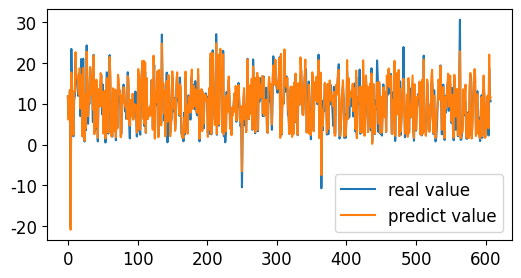

<Figure size 1000x500 with 0 Axes>

In [ ]:
cnt=len(y_test)
plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.legend()
# plt.rcParams["figure.figsize"] = (12, 3) # 10:4의 그래프 비율
plt.figure(figsize=(10, 5))
plt.show()

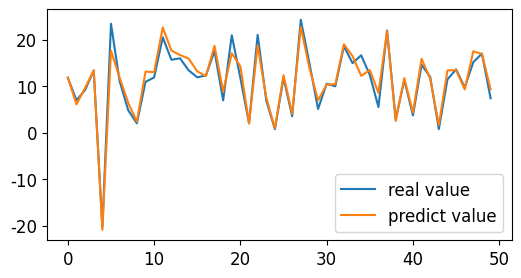

<Figure size 1000x500 with 0 Axes>

In [ ]:
cnt=50
plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.legend()
# plt.rcParams["figure.figsize"] = (12, 3) # 10:4의 그래프 비율
plt.figure(figsize=(10, 5))
plt.show()

In [ ]:
x_test[:1]

,category,net_assets,fund_yield,morningstar_rating,investment,size,currency,portfolio_cash,portfolio_stocks,portfolio_bonds,price_earnings,price_sales,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology,fund_return_2018,fund_return_2017,fund_return_2016
11824,42,1.845000e+10,2.07,3.0,2,0,0,2.34,97.63,0.03,9.9,1.03,4.78,8.53,22.45,1.9,6.24,13.19,2.62,4.74,9.25,8.13,18.18,-12.36,19.2,12.64


In [ ]:
y_test_p2 = model.predict(x_test[:1]) # 모델 사용
print(type(y_test_p2))
print(y_test_p2.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1
print(y_test_p2)

1/1 [==============================] - 0s 28ms/step
<class 'numpy.ndarray'>
(1, 1)
[[11.837403]]


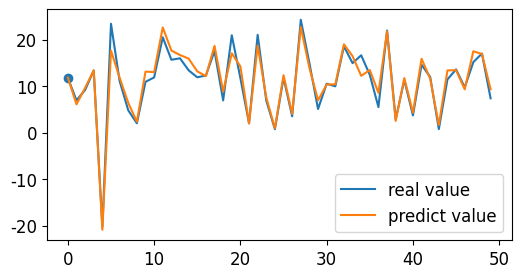

<Figure size 1000x500 with 0 Axes>

In [ ]:
cnt=50
plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.scatter(0, y_test_p2[0][0])
plt.legend()
# plt.rcParams["figure.figsize"] = (12, 3) # 10:4의 그래프 비율
plt.figure(figsize=(10, 5))
plt.show()